# Text2Cypher Agent Demo Notebook

This notebooks demonstrates a text2cypher agent with visualization capabilities. The code used to create this agent may be found in the `agents/` directory.

## Imports

In [1]:
from IPython.display import Image, display

from langchain_neo4j import Neo4jGraph
from langchain_openai import ChatOpenAI

from agents import create_text2cypher_with_visualization_agent
from agents.components.state import OutputState

## Neo4j Graph

This class handles interaction with our Neo4j database. We use `enhanced_schema` to gain more detail about the graph contents.

In [2]:
graph = Neo4jGraph(enhanced_schema=True)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


## LLM

We will be using an OpenAI LLM for this demo.

In [3]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)

## Agent

In [4]:
scope_description = "This application may answer questions related to Manufacturing Bill of Materials and supply chain management."

In [5]:
agent = create_text2cypher_with_visualization_agent(llm, graph, scope_description)

Here we can see the agent workflow. 
* The workflow always starts at `guardrails` where the input question is determined to be in scope or not.
* The workflow always ends at `final_answer` where the generated contents are formatted to be returned to the user.
* Dotted lines indicate conditional paths.

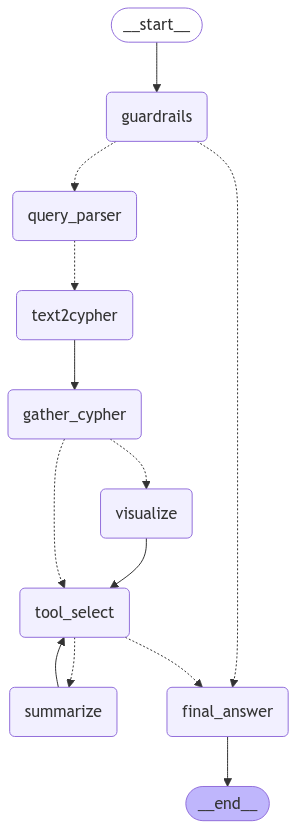

In [6]:
display(Image(agent.get_graph().draw_mermaid_png()))

We can see more detail of the Text2Cypher and Visualize subgraphs below.

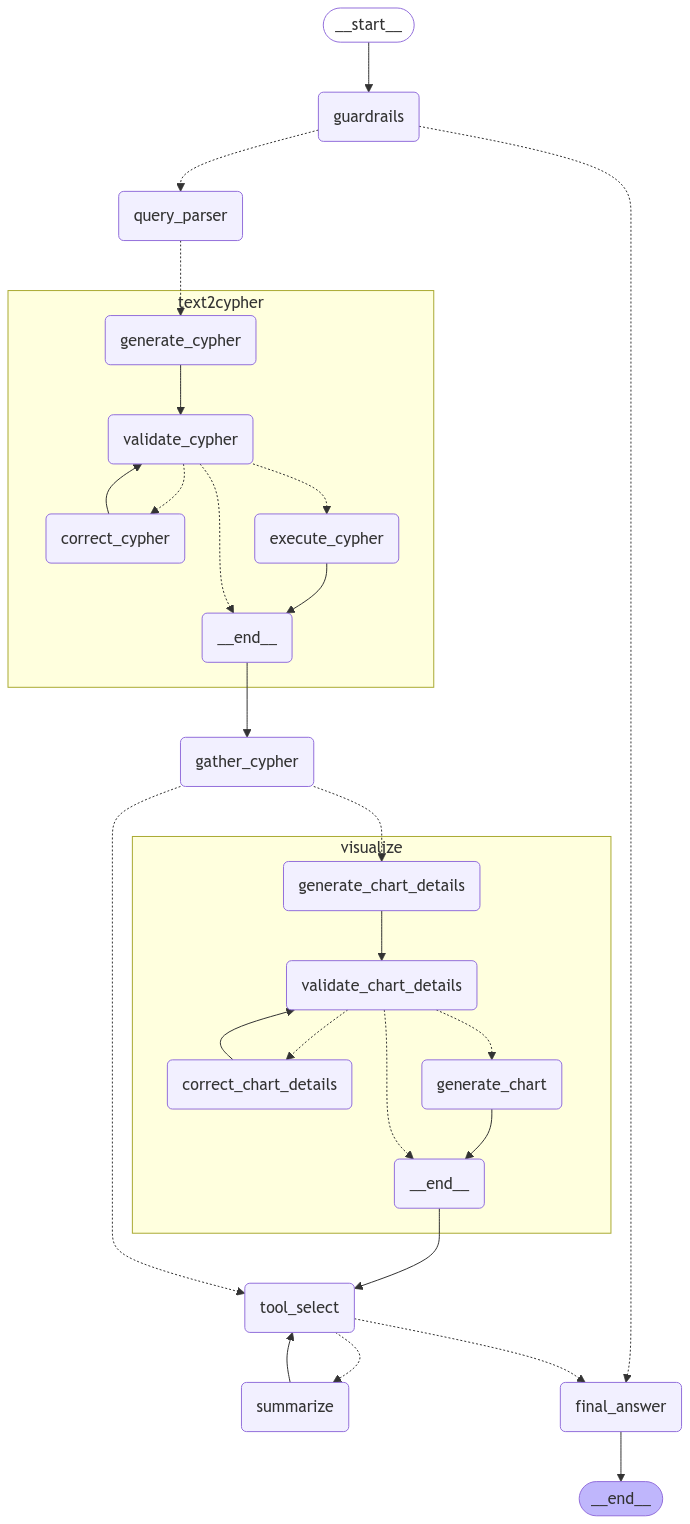

In [7]:
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

## Questions

### Helper Functions

In [41]:
def ask_question(question: str) -> OutputState:
    """wrapper to simplify asking questions in the notebook."""

    return agent.invoke({"question": question})

def print_answer(response: OutputState) -> None:
    print(response.get("question"))
    print(response.get("answer"))

def print_cypher_queries(response: OutputState) -> None:

   [print(c.get("subquestion") + "\n\n" + c.get("statement")+"\n\n") for c in response.get("cyphers")]

def print_cypher_results(response: OutputState) -> None:

    [(print(c.get("subquestion") + "\n\n"), [print(r) for r in c.get("records")], print("\n\n")) for c in response.get("cyphers")]

def print_viz_results(response: OutputState) -> None:
    [
        (print(v.get("subquestion") + "\n\n" + v.get("chart_description") + "\n\n"), display(v.get("chart"))) for v in response.get("visualizations")
    ]

The agent response is a Python dictionary with the following format:
```python
{
    answer: str,
    question: str,
    steps: List[str],
    cyphers: List[
        subquestion: str,
        statement: str,
        errors: List[str],
        records: List[Dict[str, Any]],
        next_action: str,
        steps: List[str],
    ],
    visualizations: List[
        subquestion: str
        chart: Any
        chart_description: str
        steps: List[str]
    ]
}
```

### 1. Out of Scope

The agent can detect whether a question is in scope and avoid further processing.

In [21]:
q1 = ask_question("What are the most common apple types?")

In [22]:
print_answer(q1)

What are the most common apple types?
This question is out of scope. Therefore I cannot answer this question.


We can see the agent only performs 2 steps - only `guardrails` requires an LLM call.

In [23]:
q1.get("steps")

['guardrails', 'final_answer']

### 2. Cypher Question without Visualization

The agent is capable of creating Cypher queries to answer questions within the scope of the data.

In [17]:
q2 = ask_question("What are the suppliers of TLA 86447~6814?")

In [18]:
print_answer(q2)

What are the suppliers of TLA 86447~6814?
- Supplier-20 (DECATUR-00, US)
- Supplier-57 (10001, US)
- Supplier-15 (STOUGHTON-00, US)
- Supplier-55 (AHMEDNAGAR-00, IN)
- Supplier-55 (10031, IN)
- Supplier-55 (RANJANGAON-00, IN)
- Supplier-55 (WUXI-01, CN)
- Supplier-113 (SAINT PAUL-00, US)
- Supplier-148 (10001, US)
- Supplier-165 (10001, US)
- Supplier-162 (MINNEAPOLIS-00, US)


All Cypher queries are saved for evaluation.

In [19]:
print_cypher_queries(q2)

What are the suppliers of TLA 86447~6814?

MATCH (:TLA {tla_item_uid: "86447~6814"})-[:HAS_CHILD]->(i:Item)-[:HAS_SUPPLIER]->(s:Supplier)
RETURN DISTINCT s.supplier_name, s.vendor_site_code, s.country




Results are saved as well for evaluation or futher processing.

In [37]:
print_cypher_results(q2)

What are the suppliers of TLA 86447~6814?


{'s.supplier_name': 'Supplier-20', 's.vendor_site_code': 'DECATUR-00', 's.country': 'US'}
{'s.supplier_name': 'Supplier-57', 's.vendor_site_code': '10001', 's.country': 'US'}
{'s.supplier_name': 'Supplier-15', 's.vendor_site_code': 'STOUGHTON-00', 's.country': 'US'}
{'s.supplier_name': 'Supplier-55', 's.vendor_site_code': 'AHMEDNAGAR-00', 's.country': 'IN'}
{'s.supplier_name': 'Supplier-55', 's.vendor_site_code': '10031', 's.country': 'IN'}
{'s.supplier_name': 'Supplier-55', 's.vendor_site_code': 'RANJANGAON-00', 's.country': 'IN'}
{'s.supplier_name': 'Supplier-55', 's.vendor_site_code': 'WUXI-01', 's.country': 'CN'}
{'s.supplier_name': 'Supplier-113', 's.vendor_site_code': 'SAINT PAUL-00', 's.country': 'US'}
{'s.supplier_name': 'Supplier-148', 's.vendor_site_code': '10001', 's.country': 'US'}
{'s.supplier_name': 'Supplier-165', 's.vendor_site_code': '10001', 's.country': 'US'}
{'s.supplier_name': 'Supplier-162', 's.vendor_site_code': 'MINNEA

### 3. Multi-Cypher Query Question without Visualization

The agent is capable of splitting the input question into multiple subquestions. These will be individually addressed with their own Cypher queries. 
The final answer will summarize the query results together.

In [9]:
q3 = ask_question("What are the suppliers of TLA 86447~6814 and what are all child items of finished good uid 97756?")

In [10]:
print_answer(q3)

What are the suppliers of TLA 86447~6814 and what are all child items of finished good uid 97756?
- **Suppliers of TLA 86447~6814:**
  - Supplier-20, DECATUR-00, US
  - Supplier-57, 10001, US
  - Supplier-15, STOUGHTON-00, US
  - Supplier-55, AHMEDNAGAR-00, IN
  - Supplier-55, 10031, IN
  - Supplier-55, RANJANGAON-00, IN
  - Supplier-55, WUXI-01, CN
  - Supplier-113, SAINT PAUL-00, US
  - Supplier-148, 10001, US
  - Supplier-165, 10001, US
  - Supplier-162, MINNEAPOLIS-00, US

- **Child items of finished good uid 97756:**
  - ANTIFREEZE
  - SILENCER,EXHAUST
  - GENERATOR
  - LIST,LITERATURE
  - TRANSFORMER,CURRENT
  - INSTALLATION,CONTROL BOX
  - INSTALLATION,COOLING SYSTEM
  - CODE-DES FEATURE COMMERCIAL COMMON (FUEL SYSTEM: GAS)
  - BATTERY CHARGING ALTERNATOR-NO
  - CB,Loc A,70A-250A,3P,LSI,600VAC,100%,UL
  - CODE-DES FEATURE PCC1302 (Max Over Excitation Duty Cycle (56%))
  - INSTALLATION,HARNESS
  - Enclosure - Wind Load 180MPH, ASCE7-10
  - CODE-DES FEATURE PCC1302 (Daylight Savin

In [16]:
print_cypher_queries(q3)

What are the suppliers of TLA 86447~6814?

MATCH (:TLA {tla_item_uid: "86447~6814"})-[:HAS_CHILD]->(i:Item)-[:HAS_SUPPLIER]->(s:Supplier)
RETURN DISTINCT s.supplier_name, s.vendor_site_code, s.country


What are all child items of finished good uid 97756?

MATCH (:FinishedGood {item_uid: "97756"})-[:HAS_CHILD]->(child:Item)
RETURN child.item_uid, child.description




### 4. Question with Visualization

If visualization is requested, the agent will attempt to create either a bar, line or scatter plot to fit the results gathered from Neo4j.

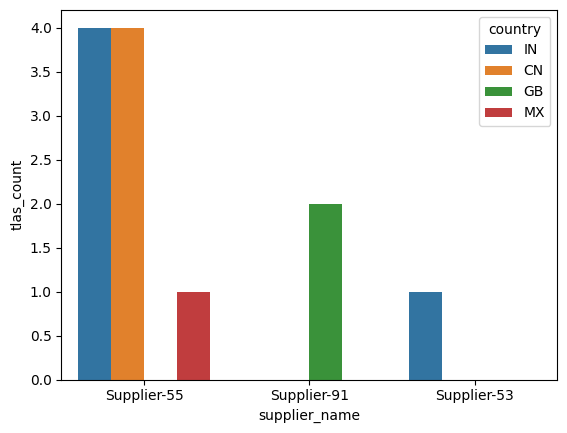

In [12]:
q4 = ask_question("What are the suppliers who operate outside the US and what are their TLA counts? visualize the result.")

We recieve a description along with each generated chart.

What are the suppliers who operate outside the US and their TLA counts?

This bar chart displays the TLA counts for suppliers who operate outside the US, categorized by supplier name and grouped by country. Each bar represents a supplier, and the color indicates the country in which they operate.




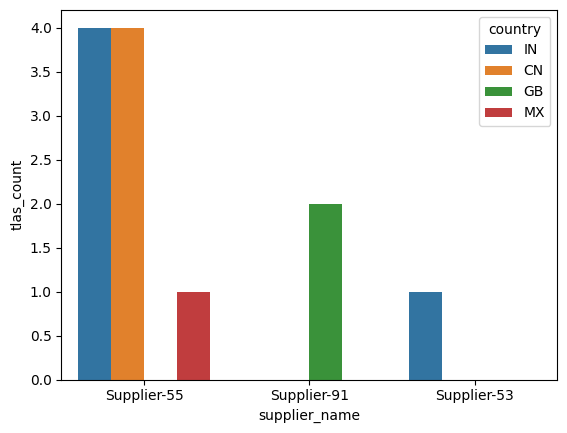

In [42]:
print_viz_results(q4)

We still recieve everything else in the result such as the summary and Cypher info.

In [13]:
print_answer(q4)

What are the suppliers who operate outside the US and what are their TLA counts? visualize the result.
- **Supplier-55**  
  - **Countries**: IN, CN, MX  
  - **TLA Count**: 4 (IN), 4 (CN), 1 (MX)

- **Supplier-91**  
  - **Country**: GB  
  - **TLA Count**: 2

- **Supplier-53**  
  - **Country**: IN  
  - **TLA Count**: 1


In [38]:
print_cypher_queries(q4)

What are the suppliers who operate outside the US and their TLA counts?

MATCH (s:Supplier)<-[:HAS_SUPPLIER]-(i:Item)<-[:HAS_CHILD]-(t:TLA)
WHERE s.country <> "US"
WITH s, count(distinct t) AS tlas_count
RETURN s.supplier_name AS supplier_name, s.vendor_site_code AS vendor_site_code, s.country AS country, tlas_count 
ORDER BY tlas_count DESC


